Cell 1 Setup & Data Loading: Import necessary libraries and load the training dataset. We apply the robust cleaning pipeline established in Task 10 to ensure column names (like 'temp') are consistent.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from scipy.optimize import linprog
import warnings

warnings.filterwarnings('ignore')

# 1. Load Training Data
df_train = pd.read_csv('train_256063_features_lean.csv')

# 2. Cleaning Pipeline (From Task 10 Audit)
df_train.columns = [c.lower().strip() for c in df_train.columns]
rename_map = {
    'temperature': 'temp',
    'load': 'demand',
    'global_radiation': 'radiation'
}
df_train = df_train.rename(columns=rename_map)
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_train = df_train.set_index('timestamp').sort_index()

print(f"✅ Training Data Loaded. Shape: {df_train.shape}")

✅ Training Data Loaded. Shape: (8736, 29)


Cell 2 Model Training: We recreate the "Full Context" model features (Lag 24h + Weather + Cyclic Time) which proved best in Task 10. We train the HistGradientBoostingRegressor on the full training set.

In [2]:
# 1. Feature Engineering
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    # Autoregressive Lag
    if 'demand' in df.columns:
        df['lag_24'] = df['demand'].shift(24)
    return df

df_train_feat = create_features(df_train).dropna()

# 2. Train Model
features = ['lag_24', 'temp', 'hour_sin', 'hour_cos']
target = 'demand'

X_train = df_train_feat[features]
y_train = df_train_feat[target]

model = HistGradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

print("✅ Model trained successfully (Features: Lag24 + Weather + Time).")

✅ Model trained successfully (Features: Lag24 + Weather + Time).


Cell 3 Forecasting Demand: We load the optimisation.csv file. To generate the necessary lag_24 feature for the first few hours of the optimization day, we pull the last 24 hours of demand from forecast.csv (the preceding day). We then predict the demand for the optimization window.

In [3]:
# 1. Load Optimization Data (The target day)
df_opt = pd.read_csv('optimisation.csv')
df_opt['timestamp'] = pd.to_datetime(df_opt['timestamp'])
df_opt = df_opt.set_index('timestamp').sort_index()

# 2. Load Historical Context for Lags (The previous day)
df_fc = pd.read_csv('forecast.csv')
df_fc['timestamp'] = pd.to_datetime(df_fc['timestamp'])
df_fc = df_fc.set_index('timestamp').sort_index()

# Get the last 24h of known demand to use as lag
last_24h_demand = df_fc['Demand'].tail(24).values

# 3. Prepare Optimization Features
df_opt = df_opt.rename(columns={'Temperature': 'temp'}) # Consistency
df_opt = create_features(df_opt)
df_opt['lag_24'] = last_24h_demand # Inject history

# 4. Predict
X_opt = df_opt[features]
df_opt['demand_pred'] = model.predict(X_opt)

print("✅ Demand Forecast generated for Optimization Window.")
print(df_opt[['demand_pred']].head())

✅ Demand Forecast generated for Optimization Window.
                           demand_pred
timestamp                             
2014-07-08 00:00:00+00:00     0.336767
2014-07-08 01:00:00+00:00     0.293997
2014-07-08 02:00:00+00:00     0.289270
2014-07-08 03:00:00+00:00     0.278647
2014-07-08 04:00:00+00:00     0.314271


Cell 4 Optimization Engine: We define a Linear Programming (LP) function to minimize electricity costs.Objective: Min $\sum (P_{import} \times Price - P_{export} \times Price)$Constraints: Power balance (Load = Grid + PV + Battery), Battery Energy balance, and physical limits (5kW power, 10kWh capacity).

In [4]:
def optimize_storage_lp(demand, pv_gen, prices):
    """
    Solves the optimal control problem using Linear Programming.
    """
    T = 24
    dt = 1 # 1 hour
    
    # System Specs
    BAT_CAP = 10.0  # kWh
    P_MAX = 5.0     # kW (Grid & Battery limit)
    E_INIT = 5.0    # Initial SOC (50%)
    
    # Decision Variables vector x (size 5*T = 120):
    # [P_grid_in(0..23), P_grid_out(0..23), P_bat_ch(0..23), P_bat_dis(0..23), E_bat(0..23)]
    # Indices offsets
    IG_IN, IG_OUT, IB_CH, IB_DIS, IE = 0, 24, 48, 72, 96
    
    # 1. Objective Function (Minimize Cost)
    # Cost = P_in * Price - P_out * Price
    c = np.zeros(5 * T)
    c[IG_IN : IG_IN+T] = prices
    c[IG_OUT : IG_OUT+T] = -prices # Negative cost = Profit
    
    # 2. Constraints
    A_eq = []
    b_eq = []
    
    for t in range(T):
        # A. Power Balance: P_in - P_out - P_ch + P_dis = Demand - PV
        # Rearranged: P_in - P_out - P_ch + P_dis = Net_Load
        row = np.zeros(5 * T)
        row[IG_IN + t] = 1
        row[IG_OUT + t] = -1
        row[IB_CH + t] = -1
        row[IB_DIS + t] = 1
        A_eq.append(row)
        b_eq.append(demand[t] - pv_gen[t])
        
        # B. Energy Balance: E(t) - E(t-1) - P_ch*dt + P_dis*dt = 0
        row_e = np.zeros(5 * T)
        row_e[IE + t] = 1
        row_e[IB_CH + t] = -dt
        row_e[IB_DIS + t] = dt # Discharge reduces SOC? 
        # Wait, standard equation: E(t) = E(t-1) + P_ch - P_dis
        # So: E(t) - P_ch + P_dis = E(t-1)
        
        if t == 0:
            A_eq.append(row_e)
            b_eq.append(E_INIT)
        else:
            row_e[IE + t - 1] = -1 # Subtract previous energy
            A_eq.append(row_e)
            b_eq.append(0)
            
    # 3. Bounds (0 to Max for all variables)
    bounds = []
    for _ in range(T): bounds.append((0, P_MAX)) # Grid In
    for _ in range(T): bounds.append((0, P_MAX)) # Grid Out
    for _ in range(T): bounds.append((0, P_MAX)) # Bat Ch
    for _ in range(T): bounds.append((0, P_MAX)) # Bat Dis
    for _ in range(T): bounds.append((0, BAT_CAP)) # Energy (SOC)
    
    # 4. Solve
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    
    # 5. Extract Results
    return {
        'cost': res.fun,
        'grid': res.x[IG_IN:IG_IN+T] - res.x[IG_OUT:IG_OUT+T],
        'soc': res.x[IE:IE+T],
        'success': res.success
    }

print("✅ Optimization engine ready.")

✅ Optimization engine ready.


Cell 5 Scenario Execution: We run the optimizer for two distinct scenarios:

PV Low: Represents a cloudy day or winter day.

PV High: Represents a sunny day. We compare the final Net Cost (Bill) for both.

In [5]:
# Prepare Inputs
prices = df_opt['Price'].values
demand_forecast = df_opt['demand_pred'].values

# Run Scenario 1: PV Low
pv_low = df_opt['pv_low'].values
res_low = optimize_storage_lp(demand_forecast, pv_low, prices)

# Run Scenario 2: PV High
pv_high = df_opt['pv_high'].values
res_high = optimize_storage_lp(demand_forecast, pv_high, prices)

print("📊 OPTIMIZATION RESULTS:")
print("="*40)
print(f"Scenario 1 (PV Low) Net Cost:  {res_low['cost']:.2f} €")
print(f"Scenario 2 (PV High) Net Cost: {res_high['cost']:.2f} €")
print("="*40)
print(f"Optimization Status: Low={res_low['success']}, High={res_high['success']}")

📊 OPTIMIZATION RESULTS:
Scenario 1 (PV Low) Net Cost:  -0.20 €
Scenario 2 (PV High) Net Cost: -1.21 €
Optimization Status: Low=True, High=True


Cell 6 Visualization: We plot the results to visually analyze the strategy.

Top: Forecasted Demand vs. PV Generation.

Middle: Grid Exchange (Positive = Buying, Negative = Selling).

Bottom: Battery State of Charge (SOC) evolution.

💾 Gráfica de optimización guardada en: results/task11\scenario_optimization_analysis.png


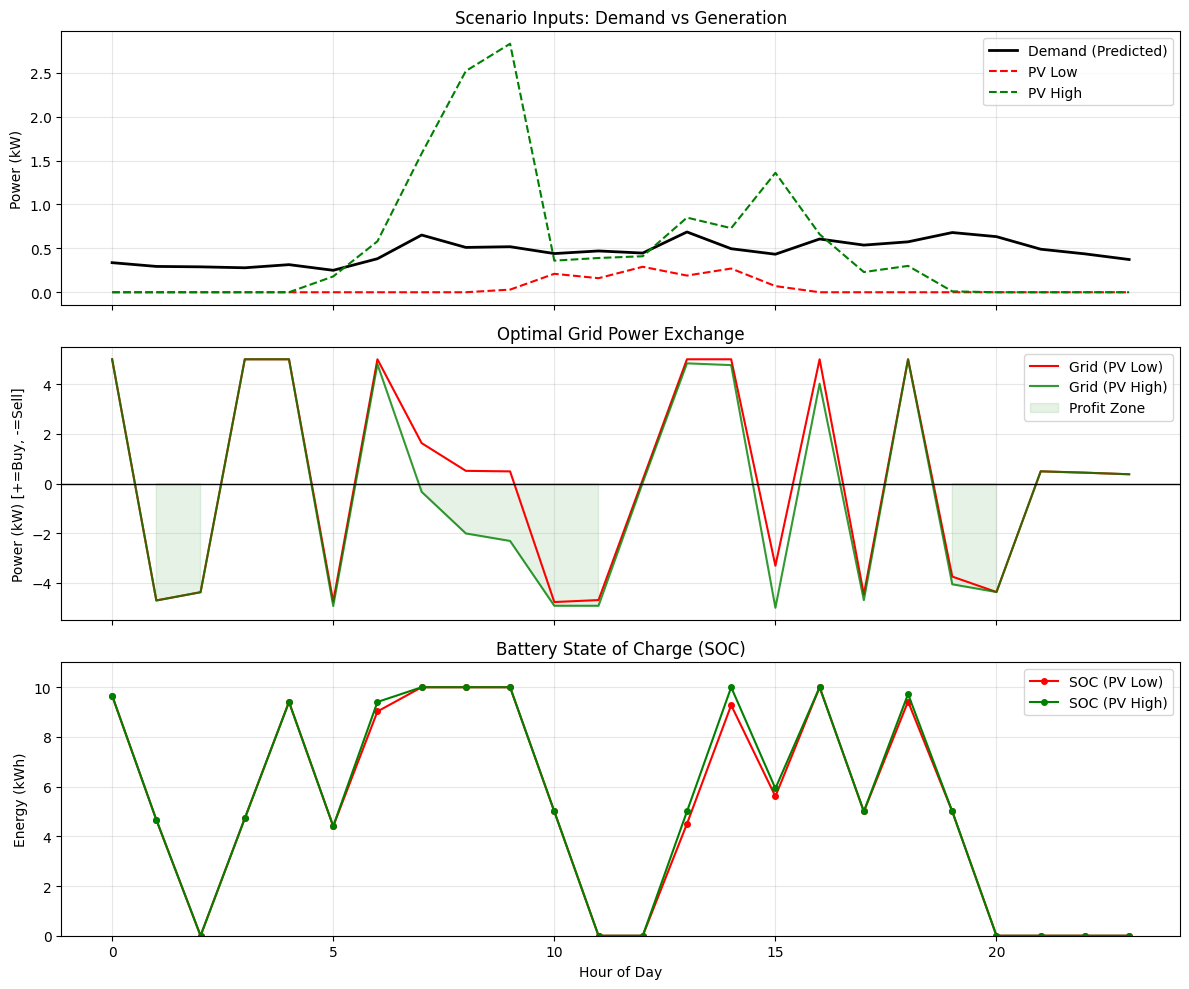

In [7]:
import matplotlib.pyplot as plt
import os

# Definir directorio y asegurar que existe
output_dir = 'results/task11'
os.makedirs(output_dir, exist_ok=True)

# Crear la figura
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot 1: Context (Demand & PV)
# Asumimos que demand_forecast, pv_low, pv_high existen de celdas anteriores
axes[0].plot(demand_forecast, 'k-', lw=2, label='Demand (Predicted)')
axes[0].plot(pv_low, 'r--', label='PV Low')
axes[0].plot(pv_high, 'g--', label='PV High')
axes[0].set_title('Scenario Inputs: Demand vs Generation')
axes[0].set_ylabel('Power (kW)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Grid Interaction
# Asumimos que res_low y res_high (resultados de optimización) existen
axes[1].plot(res_low['grid'], 'r-', label='Grid (PV Low)')
axes[1].plot(res_high['grid'], 'g-', alpha=0.8, label='Grid (PV High)')
axes[1].axhline(0, color='black', lw=1)
# Zona de beneficio (Venta a la red)
axes[1].fill_between(range(24), 0, res_high['grid'], where=res_high['grid']<0, color='green', alpha=0.1, label='Profit Zone')
axes[1].set_title('Optimal Grid Power Exchange')
axes[1].set_ylabel('Power (kW) [+=Buy, -=Sell]')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Battery State of Charge
axes[2].plot(res_low['soc'], 'r-o', markersize=4, label='SOC (PV Low)')
axes[2].plot(res_high['soc'], 'g-o', markersize=4, label='SOC (PV High)')
axes[2].set_title('Battery State of Charge (SOC)')
axes[2].set_ylabel('Energy (kWh)')
axes[2].set_xlabel('Hour of Day')
axes[2].set_ylim(0, 11) # Ajustado al tamaño típico de batería casera (ej. 10kWh)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()

# --- SAVE LOGIC START ---
# Definir nombre del archivo
filename = 'scenario_optimization_analysis.png'
save_path = os.path.join(output_dir, filename)

# Guardar antes de mostrar
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"💾 Gráfica de optimización guardada en: {save_path}")
# --- SAVE LOGIC END ---

plt.show()

# Tarea 11: Control óptimo del almacenamiento [5pt]

## Objetivo
Minimizar la factura anual de electricidad utilizando un algoritmo inteligente en un sistema de gestión de energía para el hogar (Home EMS). El objetivo es encontrar la estrategia más barata para las próximas 24 horas.

## Configuración del sistema
* **Sistema PV:** Capacidad máxima de flujo de potencia de 5 kW.
* **Batería doméstica:** Capacidad de 10 kWh, con una capacidad de carga y descarga de 5 kW.
* **Conexión a la red:** Capacidad máxima de flujo de potencia de 5 kW.

## Pasos a realizar
1.  Predecir la demanda para las próximas 24 horas y calcular el perfil de control óptimo.
2.  Comparar dos perfiles diferentes para los casos de baja y alta generación fotovoltaica (PV).